In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "c"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
# Remove features to be dropped from previous notebook
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

31


In [5]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [6]:
with open(os.path.join("results", results_subfolder, "best_common_features.txt")) as f:
    best_common_features = json.load(f)

In [7]:
all_metrics = [
    "canberra", #best metric
    cd.clark,
    # "euclidean",
    # cd.hellinger
]

In [8]:
from IPython.display import display, HTML

filepath1 = os.path.join(
    "results",
    results_subfolder,
    "distclassipy",
    "clark",
    "sfs_best_confusion_matrix.pdf",
)
filepath2 = os.path.join(
    "results",
    results_subfolder,
    "distclassipy",
    "canberra",
    "sfs_best_confusion_matrix.pdf",
)

html_str = f"""
<div style='width: 100%; display: flex;'>
    <iframe src='{filepath1}' width='50%' height='500'></iframe>
    <iframe src='{filepath2}' width='50%' height='500'></iframe>
</div>
"""

In [9]:
table1 = {
    'DSCT': 16709,
    'RR': 32518,
    'CEP': 1610,
    'RRc': 13875
}
total = sum(table1.values())
table1_ratio = {key: value / total for key, value in table1.items()}
max_ratio = max(table1_ratio.values())
sample_sizes = {key: int(494*value / max_ratio) for key, value in table1_ratio.items()}
sample_sizes

{'DSCT': 253, 'RR': 494, 'CEP': 24, 'RRc': 210}

In [10]:
HIDDENy_preds_dict = {}

  0%|          | 0/2 [00:00<?, ?it/s]

Canberra
	Expected Score from training:
		F1 = 91.22 ± 1.38%
	Actual score on hidden set:
		F1 = 93.13 %


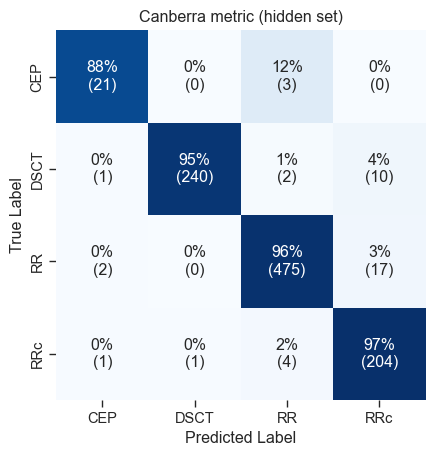

Clark
	Expected Score from training:
		F1 = 91.99 ± 0.61%
	Actual score on hidden set:
		F1 = 86.44 %


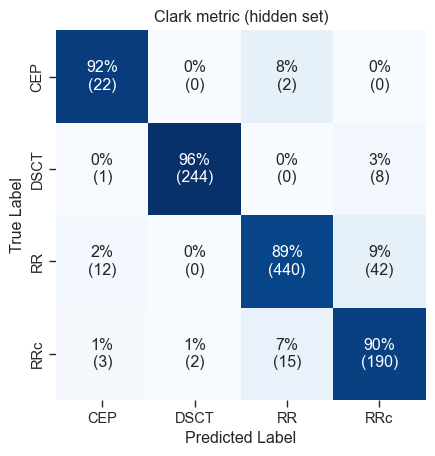

In [11]:
for metric in tqdm(all_metrics):
    metric_str = utils.get_metric_name(metric)
    locpath = os.path.join("results", results_subfolder, "distclassipy", metric_str)
    print(f"{metric_str.title()}")

    sfs_df = pd.read_csv(os.path.join(locpath, "sfs_allfeatures.csv"), index_col=0)
    feats_idx, feats = utils.load_best_features(sfs_df)

    lcdc = dcpy.DistanceMetricClassifier(
        metric=metric, scale=True, 
        central_stat=settings_dict["central_stat"], 
        dispersion_stat=settings_dict["dispersion_stat"],
        calculate_kde=False, calculate_1d_dist=False
    )

    X_df = X_df_FULL.loc[y_df.index]

    X_df = X_df.loc[:, feats]

    X = X_df.to_numpy()
    y = y_df.to_numpy().ravel()

    lcdc.fit(X, y)

    HIDDENX_df = pd.read_csv("data/HIDDENX_df_multiclass.csv", index_col=0)
    HIDDENX_df = HIDDENX_df.loc[:,X_df.columns]
    HIDDENX_df = HIDDENX_df.dropna()
    
    
    HIDDENy_df = pd.read_csv("data/HIDDENy_df_multiclass.csv", index_col=0)
    HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]
    
    
    # RESAMPLE TO BE OF RATIO OF REAL WORLD
    HIDDENy_df_resampled = []
    for cl, subdf in HIDDENy_df.groupby('class'):
        HIDDENy_df_resampled.append(
            subdf.sample(
                n=sample_sizes[cl], 
                random_state=settings_dict['seed_choice']
            )
        )
    
    HIDDENy_df = pd.concat(HIDDENy_df_resampled).sample(frac=1,random_state=settings_dict['seed_choice'])
    HIDDENX_df = HIDDENX_df.loc[HIDDENy_df.index]
    HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]

    HIDDENX_df = HIDDENX_df.loc[:, feats]
    HIDDENX_df = HIDDENX_df.dropna()
    HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]

    HIDDENX = HIDDENX_df.to_numpy()
    HIDDENy = HIDDENy_df.to_numpy().ravel()

    HIDDENy_pred = lcdc.predict_and_analyse(HIDDENX)
    HIDDENy_preds_dict[metric_str] = HIDDENy_pred

    acc = accuracy_score(y_true=HIDDENy, y_pred=HIDDENy_pred)
    f1score = f1_score(y_true=HIDDENy, y_pred=HIDDENy_pred, average="macro")
    matthew_coef = matthews_corrcoef(y_true=HIDDENy, y_pred=HIDDENy_pred)

    print("\tExpected Score from training:")
    print(
        f"\t\tF1 = {sfs_df.loc[len(feats)]['avg_score']*100:.2f} ± {sfs_df.loc[len(feats)]['std_dev']*100:.2f}%"
    )
    print("\tActual score on hidden set:")
    # print(f"\tAcc = {100*acc:.2f} %")
    print(f"\t\tF1 = {100*f1score:.2f} %")

    ax = utils.plot_cm(y_true=HIDDENy, y_pred=HIDDENy_pred)
    plt.title(f"{metric_str.title()} metric (hidden set)")
    plt.savefig(os.path.join(locpath, "hidden_cm.pdf"), bbox_inches="tight")
    # plt.savefig(f"hidden_cm/{metric_str}.pdf",bbox_inches = 'tight')
    plt.show()

In [12]:
HIDDENy_df.value_counts()

class
RR       494
DSCT     253
RRc      210
CEP       24
Name: count, dtype: int64

In [13]:
display(HTML(html_str))

In [14]:
HIDDENy_df.value_counts()

class
RR       494
DSCT     253
RRc      210
CEP       24
Name: count, dtype: int64

In [15]:
finalpredsdf = pd.DataFrame(HIDDENy_preds_dict, index=HIDDENy_df.index)
finalpredsdf["CHEN"] = HIDDENy_df["class"]
finalpredsdf

,Canberra,Clark,CHEN
oid,,,
519864,DSCT,DSCT,DSCT
63902,DSCT,DSCT,DSCT
190237,RRc,RRc,RRc
278302,RR,RR,RR
331707,RRc,RRc,RRc
...,...,...,...
574583,RR,RR,RR
394901,DSCT,DSCT,DSCT
196797,RR,RR,RR


In [16]:
incorrectchendf = finalpredsdf[
    (finalpredsdf['Canberra'] == finalpredsdf['Clark']) & 
    (finalpredsdf['Canberra'] != finalpredsdf['CHEN'])
]

In [17]:
lightcurves = pd.read_csv("/Users/sidchaini/Research/LCDistanceMetrics/phoenix/ztf_download/hidden_data_multiclass/FULLQuaternary2000.csv.gz",index_col=0)
metadata = pd.read_csv("/Users/sidchaini/Research/LCDistanceMetrics/phoenix/ztf_download/hidden_data_multiclass/subcatalog.csv",index_col=0)

lightcurves = lightcurves.loc[finalpredsdf["CHEN"].index]
metadata = metadata.loc[finalpredsdf["CHEN"].index]

In [18]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import time
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import cross_val_predict, train_test_split
import math
import ast

import os
from pathlib import Path
import pickle
import json

In [19]:
metadata.loc[63902]["Per_g"]

0.0751385

In [20]:
HIDDENX_df.loc[63902]

Period_band_r          0.075139
GP_DRW_tau_r           0.046501
Harmonics_phase_2_r    2.519625
Harmonics_phase_3_r    3.506107
Amplitude_r            0.082816
Rcs_r                  0.093869
Name: 63902, dtype: float64

In [21]:
# def plot_lightcurves(oid,lightcurves,metadata,result_df,bands="gr"):

def plot_lightcurves(oid,bands="gr"):    
    # meta = HIDDENX_df.loc[oid]
    lc = lightcurves.loc[oid]
    band_colors = {'g': "SteelBlue",'r': "IndianRed"}
    
    lc = lc.sort_values(by="mjd")
    lc["mjd"] = lc["mjd"] - lc["mjd"].min()

    # fig, (ax0,ax1) = plt.subplots(2,1)
    # defsize=(6.4*2,4.8)
    defsize=(8,4)
    fig, (ax0,ax1) = plt.subplots(1,2, 
                                  figsize=defsize, 
                                  sharey=False)

    period = HIDDENX_df.loc[oid,"Period_band_r"]
    for band in bands:
        lc_band = lc[lc["filtercode"] == f"z{band}"]
        
        mjd_band = lc_band["mjd"].to_numpy()
        mag_band = lc_band["mag"].to_numpy()
        magerr_band = lc_band["magerr"].to_numpy()
        color = band_colors[band]
        
        # Raw light curve
        ax0.errorbar(x=mjd_band, y=mag_band, c=color, yerr=magerr_band,fmt=".",label=band, ms=1)

        # Period folded light curve
        folded_mjd_band = np.mod(mjd_band, period)
        phase_band = folded_mjd_band/period
        
        ax1.errorbar(x=phase_band, y=mag_band, c=color, yerr=magerr_band,fmt=".", ms=1)
        ax1.errorbar(x=phase_band+1, y=mag_band, c=color, yerr=magerr_band,fmt=".", ms=1)

    true_class = incorrectchendf.loc[oid,'CHEN']
    canberra_pred = incorrectchendf.loc[oid,'Canberra']
    clark_pred = incorrectchendf.loc[oid,'Clark']
    # rfc_pred = incorrectchendf.loc[oid,'rfc_pred']
    
    canberra_txtcol = sns.color_palette()[2] if canberra_pred==true_class else sns.color_palette()[3]
    clark_txtcol = sns.color_palette()[2] if clark_pred==true_class else sns.color_palette()[3]
    # rfc_txtcol = sns.color_palette()[2] if rfc_pred==true_class else sns.color_palette()[3]

        
    # fig.suptitle(f"OID: {oid}\nChen Class: {true_class}\n\nCanberra Prediction:{canberra_pred}\nClark Prediction:{clark_pred}\nRFC Prediction:{rfc_pred}")
    # fig.suptitle(f"OID: {oid}\nChen Class: {true_class}\n\n{'Canberra Prediction:'.ljust(40)}\n{'Clark Prediction:'.ljust(30)}\n{'RFC Prediction:'.ljust(27)}")
    fig.suptitle(f"OID: {oid}\nChen Class: {true_class}\n\n{'Canberra Prediction:'.ljust(40)}\n{'Clark Prediction:'.ljust(30)}")
    fig.text(0.56, 0.778, canberra_pred, ha="left", va="bottom", size="large", color=canberra_txtcol)
    fig.text(0.56, 0.725, clark_pred, ha="left", va="bottom", size="large", color=clark_txtcol)
    # fig.text(0.56, 0.672, rfc_pred, ha="left", va="bottom", size="large", color=rfc_txtcol)
    
    
    # fig.suptitle(f"{meta['class'].unique()[0]}") 
    ax0.set_xlabel("Days")
    ax0.set_ylabel("Magnitude")
    ax0.invert_yaxis()
    # ax0.grid()

    ax1.set_xlabel("Phase")
    ax1.set_ylabel("Magnitude")
    # ax1.set_title(f"Period: {period_band:.2f} days")
    ax1.invert_yaxis()
    # ax1.grid()


    fig.legend(loc="lower left")
    fig.tight_layout()
    # fig.legend()

    return fig

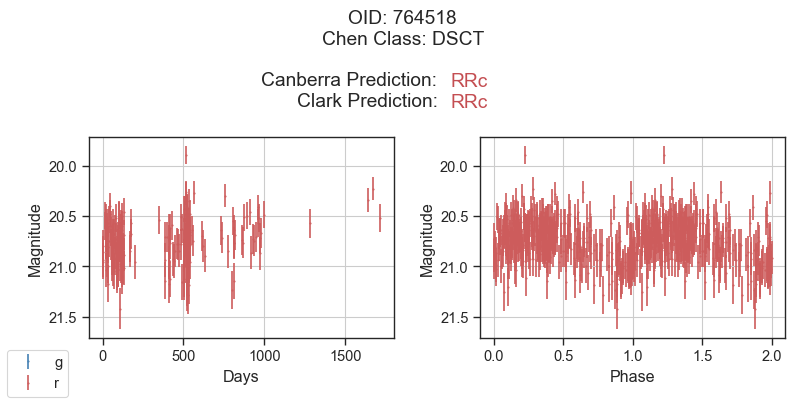

In [22]:
fig = plot_lightcurves(764518)

In [23]:
for oid in tqdm(incorrectchendf.index):
    fig = plot_lightcurves(oid)
    fig.savefig(f"lcs/{oid}.png",dpi=250,bbox_inches="tight")
    plt.close()

  0%|          | 0/22 [00:00<?, ?it/s]